In [1]:
# Restart the kernel
import os
current_dir ='../../../'
os.chdir(current_dir)

In [2]:
from src.codes.basic import *
from src.codes.utils import *
import src.codes.utils as utils

from src.codes.prob_classes.base_class_heat_conduction import FOS_FEM
from src.codes.prob_classes.base_class_heat_conduction import probdata

import src.codes.reductor.rom_class as rom_class
import src.codes.algorithms.deim_test as deim_module
from importlib import reload

reload(utils)

<module 'src.codes.utils' from 'd:\\D\\ONEDRIVE\\OneDrive - Texas A&M University\\TAMU_MATERIALS\\POSTDOC\\HYPERREDUCTION\\SUPARNO\\Hyperreduction_tamids\\pyHyperRom\\src\\codes\\utils.py'>


### class for data (geometry, material property, mesh)

In [3]:
nref= [10,10]
L = [20,20]
mat_layout = np.zeros((2,2),dtype=int)
src_layout = np.zeros((2,2),dtype=int)

In [4]:
fdict = {}

cond_list = []
cond_list.append( lambda T,mu: np.exp(mu)*T + 100. + 0.*T )
fdict["cond"] = cond_list

dcond_list = []
dcond_list.append( lambda T,mu: np.exp(mu) + 0. + 0.*T )
fdict["dcond"] = dcond_list

qext_list = []
qext_list.append( lambda T,mu: 100.0 + 0.0*T )
fdict["qext"] = qext_list

dqext_list = []
dqext_list.append( lambda T,mu: 0.0 + 0.*T)
fdict["dqext"] = dqext_list

In [5]:
bc = {}
bc['x_min']={'type':'dirichlet','value':10.0}
bc['x_max']={'type':'dirichlet','value':10.0}
bc['y_min']={'type':'dirichlet','value':10.0}
bc['y_max']={'type':'refl','value':np.nan}

### Simulate FOS

In [6]:
random.seed(25)
params = np.r_[1.:4.0:0.01]
quad_deg = 3
N_snap = 15 # Training Snapshots
NL_solutions = []
param_list = []
# 

In [7]:
def plot2Da(x, y, Z_flat, scattr=False, clr='b', sz=1.0):
    """
    Function: plot2D_surface
    Overview: This function generates a 2D surface plot utilizing heatmap coloring based on a given dataset.
    
    Inputs:
    - x, y: 1D arrays for the x and y coordinates of the data points.
    - Z_flat: Flattened 1D array corresponding to the values at each data point for the heatmap.
    
    Outputs:
    - Produces and displays a 2D surface plot with heatmap coloring.
    
    Example usage:
    plot2D_surface(x, y, Z_flat)
    
    """    
    from matplotlib import rcParams
    rcParams['mathtext.fontset'] = 'stix'
    rcParams['font.family'] = 'STIXGeneral'
    rcParams['font.size'] = 15
    plt.rc('text', usetex=True)

    X, Y = np.meshgrid(x, y)

    if scattr == False:
        sx = 4
        sy = sx * (np.max(y)-np.min(y))/ (np.max(x)-np.min(x))
        
        # Reshape the flattened Z array to 2D
        Z = Z_flat.reshape(len(y), len(x))

        fig, ax = plt.subplots(figsize=(2*sx, 2*sy),subplot_kw={"projection": "3d"})
        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=1)
        ax.view_init(elev=10, azim=-60)

        ax.scatter(X, Y, Z,s=0.1)
        ax.set_zlim(np.min(Z_flat),np.max(Z_flat))
        ax.zaxis.set_major_locator(LinearLocator(10))
        # A StrMethodFormatter is used automatically
        ax.zaxis.set_major_formatter('{x:.02f}')
        # rotate as needed
        ax.set_box_aspect(aspect=(1, sy/sx, 1))
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.set_zlabel('$T$')

        plt.colorbar(surf,shrink=0.5)

    else:

        fig, ax = plt.subplots()
        ax.scatter((X).flatten(), (Y).flatten(), c=clr, s=sz)
    
    # Remove the black frame (spines) in the front along the axes

    ax.set_xticklabels([])
    ax.set_xticks([])

    ax.set_yticklabels([])
    ax.set_yticks([])

    ax.set_zticklabels([])
    ax.set_zticks([])

    ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))  # Make x-axis spine invisible
    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))  # Make y-axis spine invisible
    ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))  # Make z-axis spine invisible
    plt.autoscale(tight=True)
    plt.show()



 Snap 0 


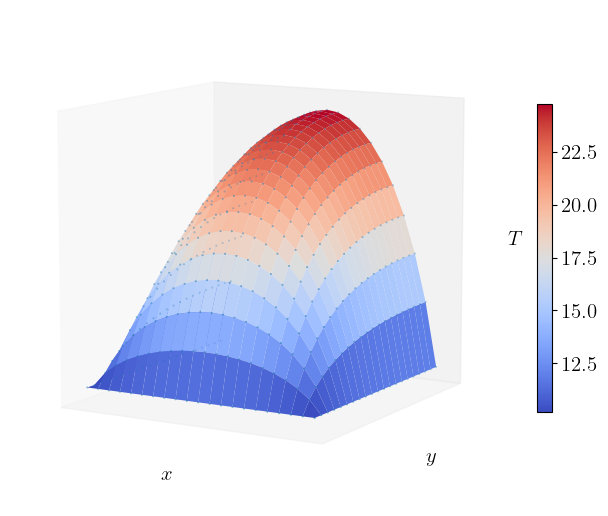


 Snap 1 

 Snap 2 

 Snap 3 

 Snap 4 

 Snap 5 

 Snap 6 

 Snap 7 

 Snap 8 

 Snap 9 

 Snap 10 

 Snap 11 

 Snap 12 

 Snap 13 

 Snap 14 


In [8]:

for i in range(N_snap):
    print(f"\n Snap {i} ")
    param = random.choice(params) # Choose from parameter list
    param_list.append(param)
    
    if i==0:
        d = probdata(bc, mat_layout, src_layout, fdict, nref, L, param, pb_dim=2)
        FOS = FOS_FEM(d,quad_deg)
    else:
        FOS.mu = param
    T_init = np.zeros(d.n_verts) + 4.0
    NL_solution_p, Ke, rhs_e, mask = solve_fos(FOS, T_init)
    NL_solutions.append(NL_solution_p.flatten())

    if i<1:
        plot2Da(d.xi[0], d.xi[1], NL_solutions[i])



In [9]:
NLS = np.asarray(NL_solutions)
np.shape(NLS)

(15, 441)

### DEIM Hyper-reduction

#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

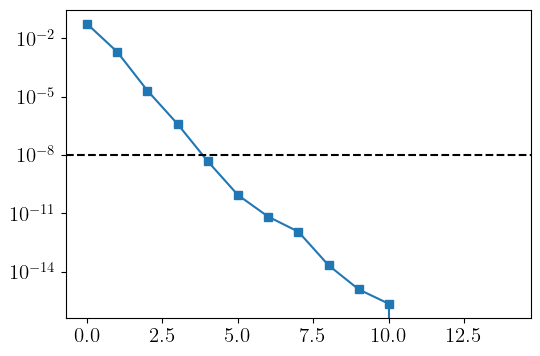

5


In [10]:
n_sel, U = svd_mode_selector(NL_solutions, tol_f=1e-8)
V_sel = U[:, :n_sel]
print(n_sel+1)

In [11]:
# for i in range(n_sel):
#     plot2D(d.xi[0], d.xi[1], V_sel[:,i])

### Step 2: Perform SVD on the force snapshots

In [31]:
deim = deim_module.deim(FOS,param_list,V_sel,NLS,mask,tol_f=1e-10)

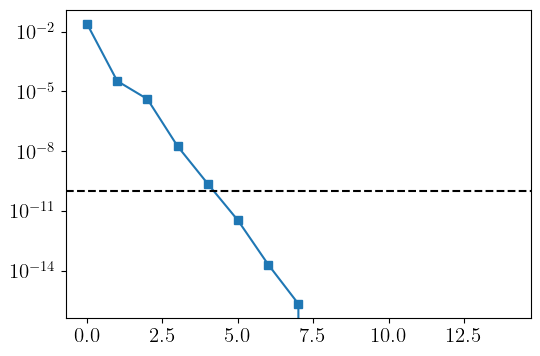

6


In [32]:
tic_h_setup_b = time.time()
deim.select_elems()
toc_h_setup_b = time.time()
print(deim.n_f_sel)

In [33]:
xi = deim.xi

colors = ['red' if value > 0 else 'blue' for value in xi]
sizes = [15 if value > 0 else 1 for value in xi]

print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")

Fraction of total elements active in the ROM: 5.5%


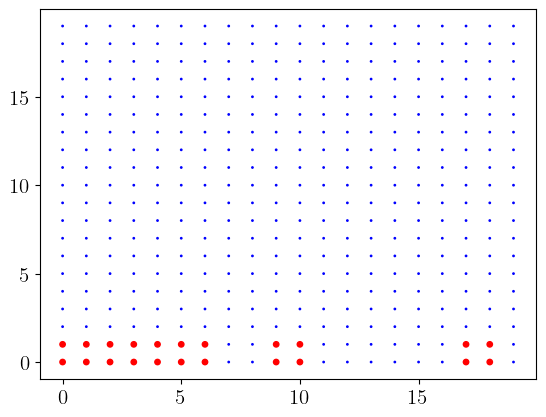

In [34]:
# reload(utils) utils.plot2D

plot2D(np.arange(d.ncells[0]),np.arange(d.ncells[1]), xi, scattr=True, clr=colors, sz=sizes)

In [35]:
mask_xi = xi>0

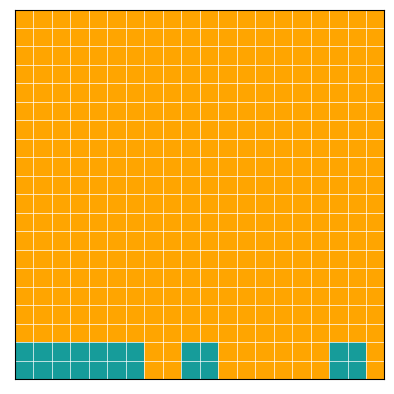

In [36]:
# Update the grid size to 20x20
grid_size = (d.ncells[0], d.ncells[1])

# Initialize the figure and axis
fig, ax = plt.subplots()

# Draw the grid lines
for x in range(grid_size[0] + 1):
    ax.axhline(x, lw=0.5, color='white')
for y in range(grid_size[1] + 1):
    ax.axvline(y, lw=0.5, color='white')


for x in range(grid_size[1]):
    for y in range(grid_size[0]):
        rect = plt.Rectangle((x, grid_size[0] - y - 1), 1, 1, linewidth=1, edgecolor='none', facecolor='orange')
        ax.add_patch(rect)

        
# Color all the cells in the specific 20x20 grid orange
for i in range(len(xi)):

    if mask_xi[i]:
        x,y = FOS.e_n_2ij(i, el=True)
        rect = plt.Rectangle((x,y), 1, 1, linewidth=1, edgecolor='none', facecolor='#169C9A')
        ax.add_patch(rect)


# Set the aspect ratio to be equal
ax.set_aspect('equal')

ax.set_yticklabels([])
ax.set_yticks([])

ax.set_xticklabels([])
ax.set_xticks([])


plt.xlim(0, grid_size[1])
plt.ylim(0, grid_size[0])
plt.show()


### ROM Simulation

In [37]:
params_rm = params[~np.isin(params,param_list)]
param_rom = random.choice(params_rm)

In [38]:
# Define the data-class

d_test = probdata(bc, mat_layout, src_layout, fdict, nref, L, param, pb_dim=2)
FOS_test = FOS_FEM(d_test,quad_deg)
ROM_h = rom_class.rom_deim(d_test, deim, quad_deg)
ROM = rom_class.rom(d_test, quad_deg)

In [39]:
# Initial guess

T_init_fos = np.zeros(FOS_test.n_nodes) + 50.0
T_init_rom = np.transpose(V_sel)@T_init_fos # crucial to ensure the initial guess is contained in the reduced subspace

In [40]:
# Time taken to perform a FO simulation with the current parameter value

tic_fos = time.time()
NL_solution_p_fos_test, _, _, _, = solve_fos(FOS_test,T_init_fos)
toc_fos = time.time()

In [41]:
# Time taken to simulate a ROM without hyper-reduction

tic_rom_woh = time.time()
NL_solution_p_reduced_woh = ROM.solve_rom(T_init_rom,V_sel)
toc_rom_woh = time.time()

c:\Users\supar\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [42]:
# # Time taken to simulate a ROM *with* hyper-reduction

tic_rom = time.time()
NL_solution_p_reduced_test = ROM_h.solve_rom(T_init_rom,xi,V_sel)
toc_rom = time.time()

In [43]:
speed_up = []
fos_sim_time = toc_fos - tic_fos

for i in range(100):
    param_rom = random.choice(params_rm)
    d_test.mu = param_rom

    tic_rom = time.time()
    ROM_h = rom_class.rom_deim(d_test, deim, quad_deg)
    NL_solution_p_reduced_loop = ROM_h.solve_rom(T_init_rom,xi,V_sel)
    toc_rom = time.time()
    
    rom_sim_time = toc_rom - tic_rom
    speed_up.append(fos_sim_time/(rom_sim_time))
    

#### Small Testing block

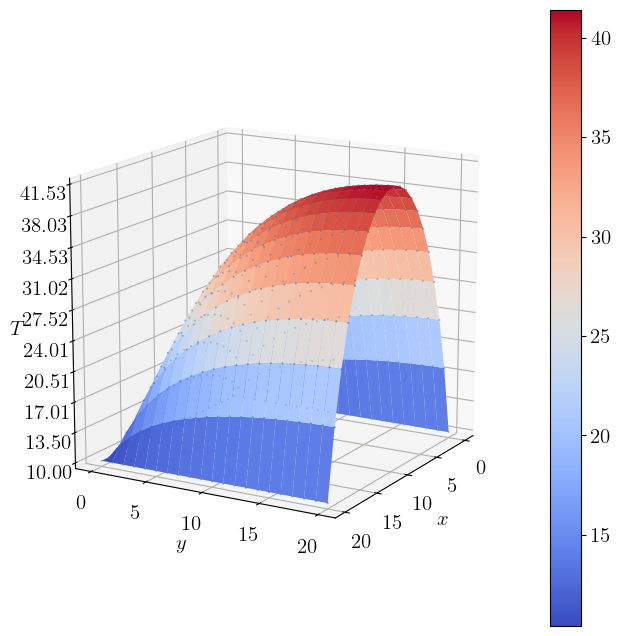

RMS_error is 0.0014222987878284709 %


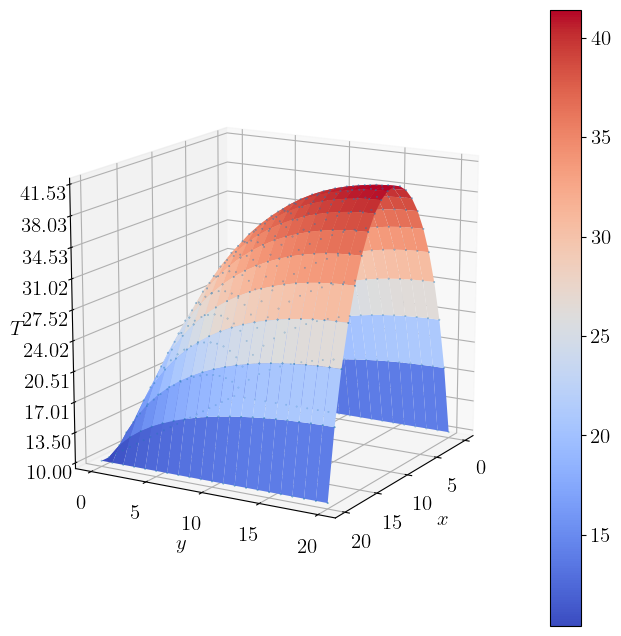

In [44]:
FOS_test_loop = FOS_FEM(d_test,quad_deg)
NL_solution_p_fos_test_loop, _, _, _, = solve_fos(FOS_test_loop,T_init_fos)

sol_red_loop = V_sel@NL_solution_p_reduced_loop.reshape(-1,1)  #+pca.mean_.reshape(-1,1)
plot2D(d_test.xi[0], d_test.xi[1], sol_red_loop)

print(f"RMS_error is {np.linalg.norm(sol_red_loop-NL_solution_p_fos_test_loop.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test_loop.reshape(-1,1))} %")
plot2D(d_test.xi[0], d_test.xi[1], NL_solution_p_fos_test_loop)

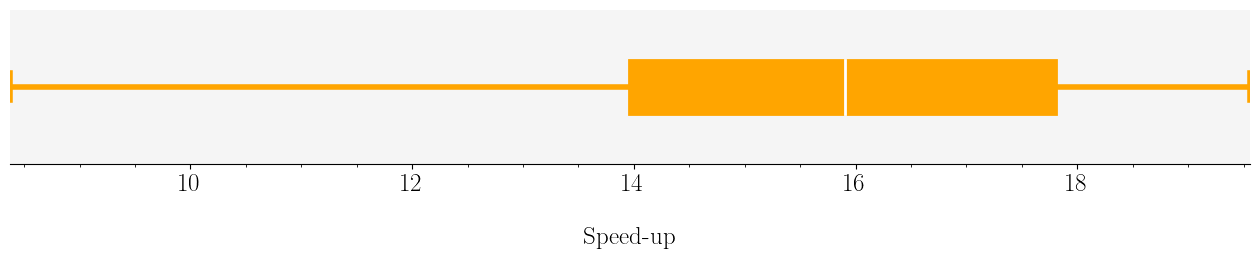

In [45]:
from matplotlib import rcParams

# rcParams['font.family'] = 'Latin Modern Roman 10'
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.size'] = 18

# Create Figure and Axes
fig, ax = plt.subplots(figsize=(8*2, 1*2))
ax.set_facecolor('#f5f5f5')  # Using the HEX code for gray

# Create Box Plot with patch_artist=True
box = ax.boxplot(speed_up, vert=False, patch_artist=True,widths=0.35,
                 boxprops=dict(linewidth=2.0, color='orange'),
                 whiskerprops=dict(linewidth=4.0, color='orange'),
                 capprops=dict(linewidth=4.0, color='orange'),
                 medianprops=dict(linewidth=2.0, color='white'),
                 flierprops=dict(marker='.', markerfacecolor='#ffb300', markeredgecolor='#ffb300', markersize=8, linestyle='none'))


ax.set_ylim(0.9, 1.1)

# Set Box Fill Color
for patch in box['boxes']:
    patch.set_facecolor('orange')

for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

ax.set_yticklabels([])
ax.set_yticks([])
plt.xlabel('\n Speed-up')
plt.autoscale(enable=True, tight=True)
ax.minorticks_on()

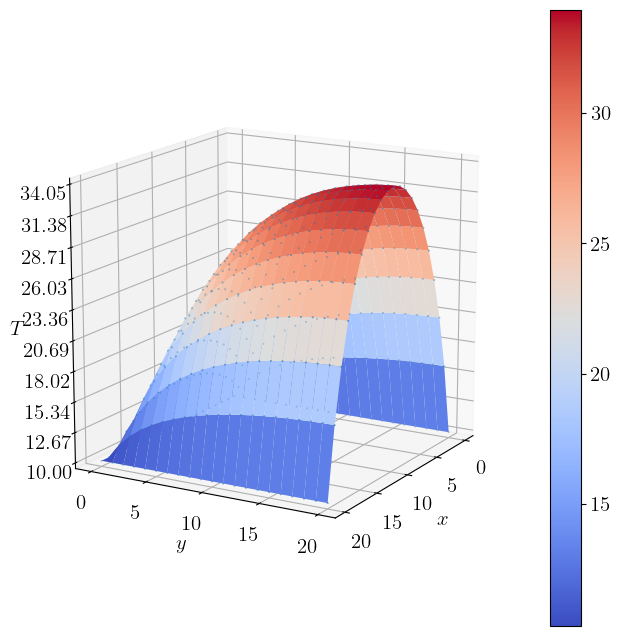

RMS_error is 0.00015096210972843636 %


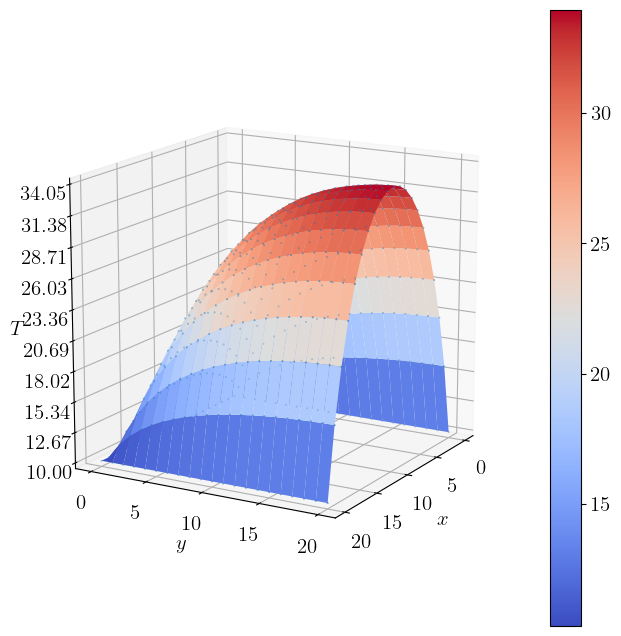



ROM Error without hyperreduction is 9.369745382581075e-06 %


In [46]:
sol_red = V_sel@NL_solution_p_reduced_test.reshape(-1,1)  #+pca.mean_.reshape(-1,1)
plot2D(d_test.xi[0], d_test.xi[1], sol_red)

print(f"RMS_error is {np.linalg.norm(sol_red-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")
plot2D(d_test.xi[0], d_test.xi[1], NL_solution_p_fos_test)

print(f"\n\nROM Error without hyperreduction is {np.linalg.norm(V_sel@NL_solution_p_reduced_woh.reshape(-1,1)-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")


#### Speedups

In [47]:
fos_sim_time = toc_fos - tic_fos
rom_sim_time_woh = toc_rom_woh - tic_rom_woh
rom_sim_time = toc_rom - tic_rom

In [48]:
print(f"speedup without hyperreduction:{fos_sim_time/rom_sim_time_woh}")
print(f"speedup with hyperreduction:{fos_sim_time/(rom_sim_time)}")
# h_total_setup_time = (toc_h_setup_b+toc_h_setup_a) - (tic_h_setup_b+tic_h_setup_a) #this is one time

speedup without hyperreduction:0.8016867835235647
speedup with hyperreduction:17.99875723339054
